# 2c)

Importamos las librerías/funciones necesarias.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from scipy.stats import beta

Definimos funciones generales

In [2]:
def aceptacion_rechazo(N, M, f, g, r = False):
    '''
    Si r es True se devuelve los puntos rechazados dentro del loop.
    '''
    n, aceptados, rechazados = 0, [], []
    while n < N:
        u = np.random.uniform(0,1)
        y = g(sim=True)
        if u <= f(y)/(M*g(y)):
            aceptados.append([y, u*M*g(y)])
            n += 1
        else:
            rechazados.append([y, u*M*g(y)])
    return (np.array(aceptados), np.array(rechazados)) if r == True else np.array(aceptados)[:,0]

def Algo3(h,g,M,recursiones=1):
    x = g(sim=True)
    u = np.random.uniform(0,1)
    if u < h(x)/(M*g(x)):
        return np.hstack((x,recursiones))
    else:
        recursiones+=1
        return Algo3(h,g,M,recursiones)

def graficar_resultados_accept_reject(aceptados, rechazados, f, g, M, puntos):
    plt.figure(figsize = (8,6))
    # PUNTOS
    plt.scatter(aceptados[:,0], aceptados[:,1],
                c='blue', s=10,
                label='Aceptados',
                )
    plt.scatter(rechazados[:,0], rechazados[:,1],
                c='red', s=10,
                label='Rechazados')
    # LINEAS
    plt.plot(puntos, f(puntos),
             c='black', ls='--', lw=3,
             label = 'Densidad objetivo')
    plt.plot(puntos, M * g(puntos),
             c='black', lw=3,
             label = f'({M=}) * Densidad instrumental')
    plt.title(f'Puntos generados por Aceptación - Rechazo')
    plt.legend();

Para comparar los métodos de simulación utilizaremos el ejemplo 5.6.7 del libro: Statistical Inference, Casella, George, and Roger Berger. 2001.

Definimos las funciones:
<!-- 
https://rh8liuqy.github.io/Accept_reject.html
 -->

In [3]:
f = lambda x:  beta(2.7, 6.3).pdf(x)
g_1 = np.vectorize(lambda x=0, sim=False: np.random.uniform(0,1) if sim == True else 1)

Generamos las simulaciones desde Aceptación - Rechazo:

In [4]:
%%time
N = 10_000
M_1 = 2.669
aceptados, rechazados = aceptacion_rechazo(N, M_1, f, g_1, r = True)

CPU times: total: 11.8 s
Wall time: 33.8 s


Se espera una tasa de aceptación:

In [5]:
1/M_1

0.37467216185837393

Visualicemos los puntos aceptados y rechazados:

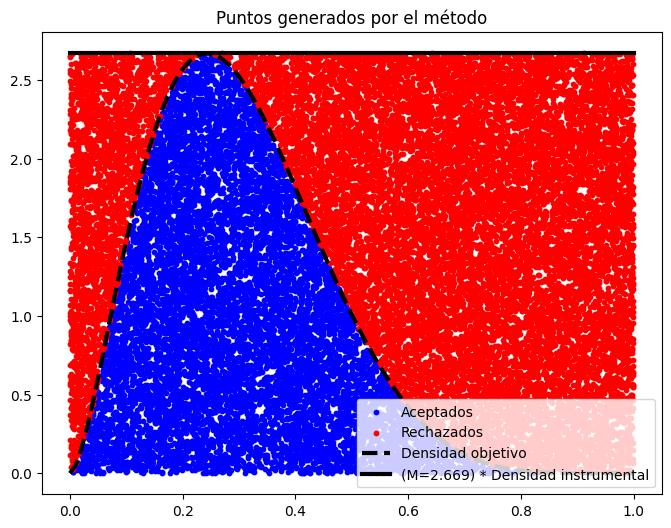

In [6]:
puntos = np.linspace(0,1,100)
graficar_resultados_accept_reject(aceptados, rechazados, f, g_1, M_1, puntos)

Otro ejemplo podría ser el 5.6.9 del mismo libro:

``` python

f = lambda x:  beta(2.7, 6.3).pdf(x)
g_2 = np.vectorize(lambda x = 0, sim = False: beta(2,6).rvs() if sim == True else beta(2,6).pdf(x))

N = 1_000
M_2 = 1.67
aceptados, rechazados = aceptacion_rechazo(N, M_2, f, g_2, r = True)

1/M_2

graficar_resultados_accept_reject(aceptados, rechazados, f, g_2, M_2, puntos)
```

## Comparamos métodos

Generamos N simulaciones desde cada método para crear los histogramas normalizados.

In [7]:
N = 10_000

In [8]:
%%time
algoritmo = np.array([Algo3(f,g_1,M_1) for _ in range(N)])

CPU times: total: 10.1 s
Wall time: 34.2 s


In [9]:
%%time
aceptados, rechazados = aceptacion_rechazo(N, M_1, f, g_1, r = True)

CPU times: total: 6.69 s
Wall time: 24.3 s


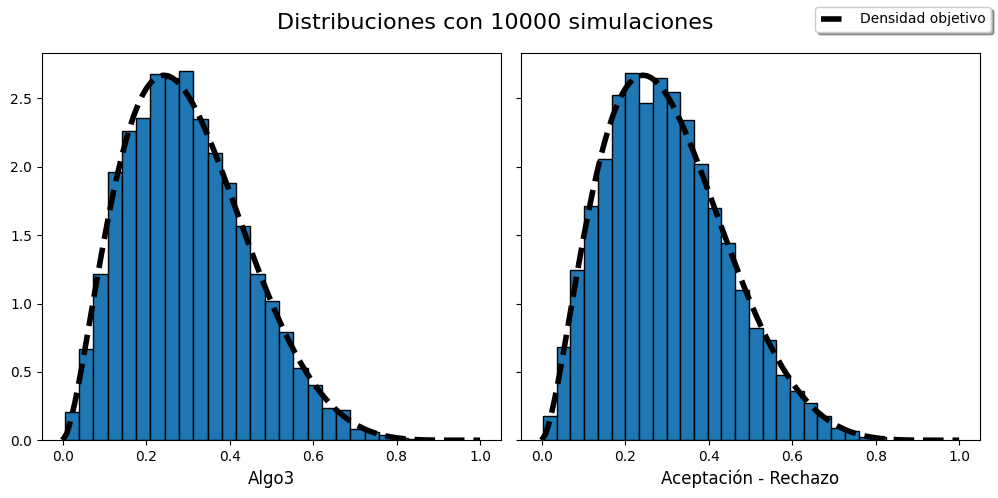

In [16]:
fig, axs = plt.subplots(1,2,sharex=True, sharey=True, figsize=(10,5))

axs[0].hist(algoritmo[:,0], bins=25, density=True, edgecolor='k')
axs[0].plot(puntos,f(puntos), lw=4, ls='--', c='k', label='Densidad objetivo')
axs[0].set_xlabel('Algo3', size=12)

axs[1].hist(aceptados[:,0], bins=25, density=True, edgecolor='k')
axs[1].plot(puntos,f(puntos), lw=4, ls='--', c='k')
axs[1].set_xlabel('Aceptación - Rechazo', size=12)

fig.suptitle(f'Distribuciones con {N} simulaciones', size=16)
fig.legend(shadow=True, fontsize=10)
fig.tight_layout()

Comparamos los tiempos de computo en (s) generando 'repeat' veces 'N' simulaciones.

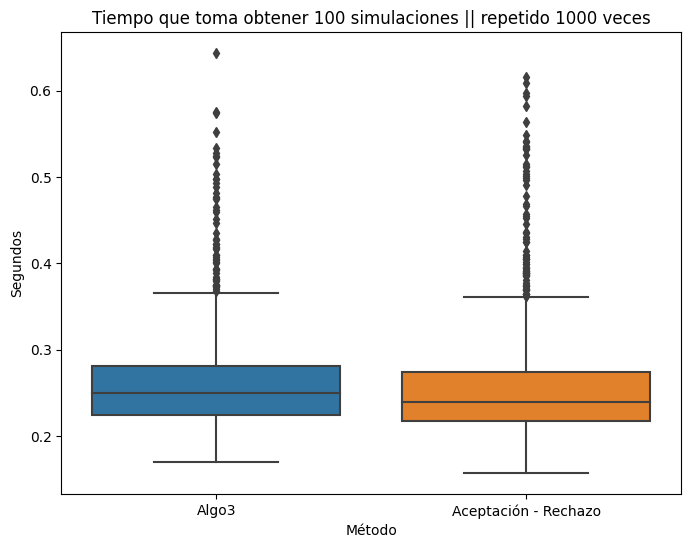

In [17]:
N = 100
repeat = 1000

algo3_time = timeit.repeat(lambda : [Algo3(f,g_1,M_1) for _ in range(N)], repeat = repeat, number = 1)
ac_re_time = timeit.repeat(lambda : aceptacion_rechazo(N, M_1, f, g_1, r = True), repeat = repeat, number = 1)

df_plot = pd.concat((
    pd.DataFrame({"Segundos":algo3_time,"Método":"Algo3"}),
    pd.DataFrame({"Segundos":ac_re_time,"Método":"Aceptación - Rechazo"})
))
plt.figure(figsize=(8,6))
sns.boxplot(x = "Método", y = "Segundos", data = df_plot)
plt.title(f"Tiempo que toma obtener {N} simulaciones || repetido {repeat} veces")
plt.show()

Calculamos las medias de los tiempos de ejecución al generar 'N' simulaciones.

In [18]:
np.mean(algo3_time), np.mean(ac_re_time)

(0.2617785312001943, 0.2579980634995736)

Comparamos las iteraciones necesarias para aceptar una simulación en cada método, generamos 'repeat' simulaciones.

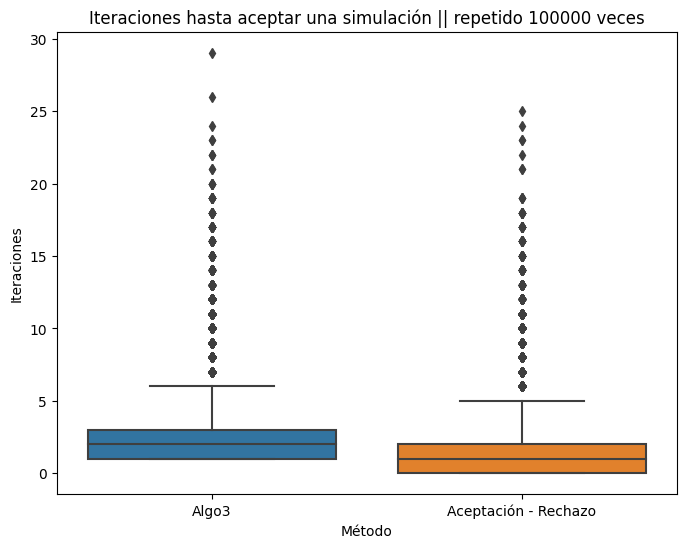

In [19]:
repeat = 100_000

algo3_iter = np.array([Algo3(f,g_1,M_1)[1] for _ in range(repeat)])
ac_re_iter = np.array([aceptacion_rechazo(1,M_1,f,g_1,r=True)[1].shape[0] for _ in range(repeat)])

df_plot = pd.concat((
    pd.DataFrame({"Iteraciones":algo3_iter,"Método":"Algo3"}),
    pd.DataFrame({"Iteraciones":ac_re_iter,"Método":"Aceptación - Rechazo"})
))
plt.figure(figsize=(8,6))
sns.boxplot(x = "Método", y = "Iteraciones", data = df_plot)
plt.title(f"Iteraciones hasta aceptar una simulación || repetido {repeat} veces")
plt.show()

Calculamos las medias de las iteraciones que toma aceptar una simulación.

In [20]:
algo3_iter.mean(), ac_re_iter.mean()

(2.67684, 1.66788)